In [6]:
from covNeut_bert_mlm import CovBind_MLM as BERT_MLM
from covNeut_bert_mlm import SequenceDataset as bert_dataset

from covNeut_bert_mlm_struct import CovBind as BERT_MLM_Struct
from covNeut_bert_mlm_struct import SequenceDataset as bert_struct_dataset

from covNeut_esm2 import CovBind_ESM2 as esm2 
from covNeut_esm2 import SequenceDataset as esm2_dataset

from covNeut_esm2_mlm import CovBind_ftESM as esm2_mlm 
from covNeut_esm2_mlm import SequenceDataset as esm2_mlm_dataset

from covNeut_esm2_struct import CovNeut_ftESM as esm2_struct 
from covNeut_esm2_struct import SequenceDataset as esm2_struct_dataset

import torch 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd 
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [8]:
tpr = {} 
fpr = {} 
auc = {} 

### BERT-MLM

In [9]:
def test_run_with_roc_auc(model, data_loader, device):
    model.to(device)
    model.eval()
    all_logits = []  # Raw model outputs
    all_actual_class = []  # Ground truth labels
    with torch.no_grad():
        for vh_ids, vh_masks, vl_ids, vl_masks, ag_embs, labels in tqdm(data_loader, desc="Validating"):
            vh_ids, vh_masks = vh_ids.to(device), vh_masks.to(device) 
            vl_ids, vl_masks = vl_ids.to(device), vl_masks.to(device)
            ag_embs = ag_embs.to(device) 
            labels = labels.to(device)
            
            logits = model(vh_ids, vh_masks, vl_ids, vl_masks, ag_embs)
            all_logits.extend(logits.view(-1).tolist())  # Store raw outputs
            all_actual_class.extend(labels.view(-1).tolist())  # Store ground truth
            
    return all_actual_class, all_logits 

In [10]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = bert_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Neutralizing'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)


In [11]:
model = BERT_MLM()   
model_savepath = 'saved_models/covNeut_bert_mlm_pt.pth'
model.load_state_dict(torch.load(model_savepath), strict=False) 

cls, logits = test_run_with_roc_auc(model, data_loader_test, device)  
fpr['BERT+MLM (Frozen)'], tpr['BERT+MLM (Frozen)'], _ = roc_curve(cls, logits)
auc['BERT+MLM (Frozen)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:04<00:00, 20.42it/s]


In [12]:
model = BERT_MLM(freeze=False)   
model_savepath = 'saved_models/covNeut_bert_mlm_ft.pth'
model.load_state_dict(torch.load(model_savepath), strict=False) 

cls, logits = test_run_with_roc_auc(model, data_loader_test, device)  
fpr['BERT+MLM (Finetuned)'], tpr['BERT+MLM (Finetuned)'], _ = roc_curve(cls, logits)
auc['BERT+MLM (Finetuned)'] = roc_auc_score(cls, logits) 

Validating: 100%|██████████| 84/84 [00:03<00:00, 23.12it/s]


In [13]:
auc

{'BERT+MLM (Frozen)': 0.7178041369638892,
 'BERT+MLM (Finetuned)': 0.8781699193642634}

### BERT-MLM-Struct

In [14]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = bert_struct_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Neutralizing'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

In [15]:
model = BERT_MLM_Struct()   
savepath = "saved_models/covNeut_mlm_struct_pt.pth" 
model.load_state_dict(torch.load(savepath), strict=False) 

cls, logits = test_run_with_roc_auc(model, data_loader_test, device) 
fpr['BERT+MLM+Struct (Frozen)'], tpr['BERT+MLM+Struct (Frozen)'], _ = roc_curve(cls, logits)
auc['BERT+MLM+Struct (Frozen)'] = roc_auc_score(cls, logits) 

Validating: 100%|██████████| 84/84 [00:05<00:00, 14.63it/s]


In [16]:
model = BERT_MLM_Struct()   
savepath = "saved_models/covNeut_mlm_struct_ft.pth" 
model.load_state_dict(torch.load(savepath), strict=False) 

cls, logits = test_run_with_roc_auc(model, data_loader_test, device)  
fpr['BERT+MLM+Struct (Finetuned)'], tpr['BERT+MLM+Struct (Finetuned)'], _ = roc_curve(cls, logits)
auc['BERT+MLM+Struct (Finetuned)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:05<00:00, 14.90it/s]


### ESM-2

In [17]:
def test_run2_with_roc_auc(model, data_loader, device):
    model.to(device)
    model.eval()
    all_logits = []  # Raw model outputs
    all_actual_class = []  # Ground truth labels
    with torch.no_grad():
        for vh_ids,  vl_ids, ag_embs, labels in tqdm(data_loader, desc="Validating"):
            vh_ids = vh_ids.to(device) 
            vl_ids = vl_ids.to(device)
            ag_embs = ag_embs.to(device) 
            labels = labels.to(device)
            logits = model(vh_ids, vl_ids, ag_embs)
            all_logits.extend(logits.view(-1).tolist())  # Store raw outputs
            all_actual_class.extend(labels.view(-1).tolist())  # Store ground truth
            
    return all_actual_class, all_logits 

In [18]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = esm2_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Neutralizing'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

In [19]:
model_savepath = 'saved_models/covNeut_ESM2_pt.pth' 
model = esm2() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2 (Frozen)'], tpr['ESM2 (Frozen)'], _ = roc_curve(cls, logits)
auc['ESM2 (Frozen)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:09<00:00,  8.46it/s]


In [20]:
model_savepath = 'saved_models/covNeut_ESM2_ft.pth' 
model = esm2() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 
cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2 (Finetuned)'], tpr['ESM2 (Finetuned)'], _ = roc_curve(cls, logits)
auc['ESM2 (Finetuned)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:09<00:00,  8.42it/s]


### ESM2-MLM

In [21]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = esm2_mlm_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Neutralizing'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

In [22]:
model_savepath = 'saved_models/covNeut_ESM2_MLM_pt.pth' 
model = esm2_mlm() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2+MLM (Frozen)'], tpr['ESM2+MLM (Frozen)'], _ = roc_curve(cls, logits)
auc['ESM2+MLM (Frozen)'] = roc_auc_score(cls, logits)


Validating: 100%|██████████| 84/84 [00:10<00:00,  8.40it/s]


In [23]:
model_savepath = 'saved_models/covNeut_ESM2_MLM_ft.pth' 
model = esm2_mlm() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2+MLM (Finetuned)'], tpr['ESM2+MLM (Finetuned)'], _ = roc_curve(cls, logits)
auc['ESM2+MLM (Finetuned)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:10<00:00,  8.38it/s]


In [24]:
auc

{'BERT+MLM (Frozen)': 0.7178041369638892,
 'BERT+MLM (Finetuned)': 0.8781699193642634,
 'BERT+MLM+Struct (Frozen)': 0.7167774086378738,
 'BERT+MLM+Struct (Finetuned)': 0.8853528439539893,
 'ESM2 (Frozen)': 0.6597480759278117,
 'ESM2 (Finetuned)': 0.8887251873987879,
 'ESM2+MLM (Frozen)': 0.7031461293176847,
 'ESM2+MLM (Finetuned)': 0.8757241356283076}

### ESM2-Struct

In [25]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = esm2_struct_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Neutralizing'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

In [26]:
model_savepath = 'saved_models/covneut_ESM2_Struct_pt.pth' 
model = esm2_struct() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2+MLM+Struct (Frozen)'], tpr['ESM2+MLM+Struct (Frozen)'], _ = roc_curve(cls, logits)
auc['ESM2+MLM+Struct (Frozen)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:15<00:00,  5.31it/s]


In [27]:
model_savepath = 'saved_models/covneut_ESM2_Struct_ft.pth' 
model = esm2_struct() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2+MLM+Struct (Finetuned)'], tpr['ESM2+MLM+Struct (Finetuned)'], _ = roc_curve(cls, logits)
auc['ESM2+MLM+Struct (Finetuned)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:15<00:00,  5.30it/s]


### ROC-AUC

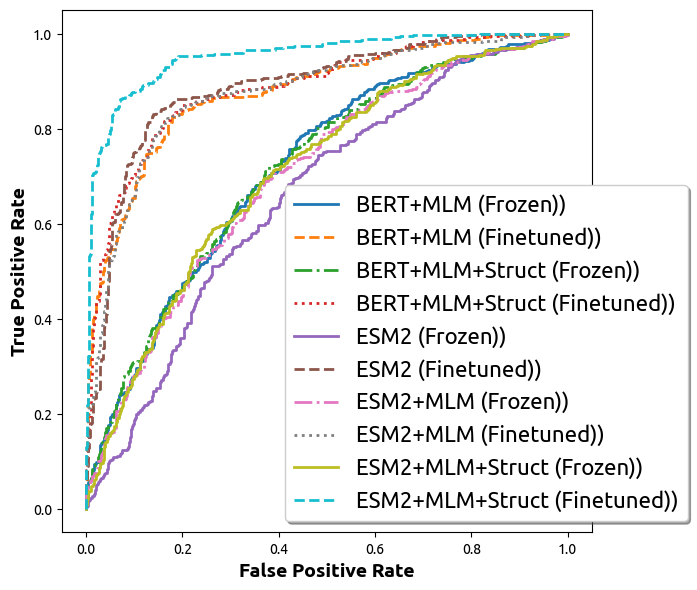

In [49]:

from matplotlib import rcParams

# Set global font to Arial
rcParams['font.family'] = 'Ubuntu'

# Define colors and styles
prism_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(7, 6))
for i, key in enumerate(fpr.keys()):
    color = prism_colors[i % len(prism_colors)]
    linestyle = line_styles[i % len(line_styles)]
    plt.plot(fpr[key], tpr[key], label=f"{key})", color=color, linestyle=linestyle, linewidth=2)

# Enhance aesthetics
plt.xlabel("False Positive Rate", fontsize=14, weight='bold')
plt.ylabel("True Positive Rate", fontsize=14, weight='bold')
#plt.title("ROC Curve", fontsize=16, weight='bold')
#plt.grid(visible=True, linestyle='--', alpha=0.5, color='gray')
# plt.legend(fontsize=14, frameon=True, loc='lower right', fancybox=True, shadow=True, borderpad=1)
plt.legend(fontsize=16, loc='lower left', bbox_to_anchor=(0.4, 0), frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig('roc_neut_prism.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [50]:
for i, key in enumerate(fpr.keys()):
    print(f"{key} AUC={auc[key]:.4f}")

BERT+MLM (Frozen) AUC=0.7178
BERT+MLM (Finetuned) AUC=0.8782
BERT+MLM+Struct (Frozen) AUC=0.7168
BERT+MLM+Struct (Finetuned) AUC=0.8854
ESM2 (Frozen) AUC=0.6597
ESM2 (Finetuned) AUC=0.8887
ESM2+MLM (Frozen) AUC=0.7031
ESM2+MLM (Finetuned) AUC=0.8757
ESM2+MLM+Struct (Frozen) AUC=0.7096
ESM2+MLM+Struct (Finetuned) AUC=0.9538


In [51]:
for i, key in enumerate(fpr.keys()):
    print(f"{key} AUC={auc[key]:.4f}")
    
    break 

BERT+MLM (Frozen) AUC=0.7178
[0.         0.         0.         0.00166113 0.00166113 0.00332226
 0.00332226 0.00498339 0.00498339 0.00830565 0.00830565 0.00996678
 0.00996678 0.01328904 0.01328904 0.01495017 0.01495017 0.0166113
 0.0166113  0.02159468 0.02159468 0.0282392  0.0282392  0.02990033
 0.02990033 0.03156146 0.03156146 0.03488372 0.03488372 0.03820598
 0.03820598 0.04318937 0.04318937 0.0448505  0.0448505  0.04651163
 0.04651163 0.04983389 0.04983389 0.05149502 0.05149502 0.05315615
 0.05315615 0.05980066 0.05980066 0.06146179 0.06146179 0.06312292
 0.06312292 0.06478405 0.06478405 0.06644518 0.06644518 0.06810631
 0.06810631 0.0730897  0.0730897  0.07807309 0.07807309 0.07973422
 0.07973422 0.08471761 0.08471761 0.09136213 0.09136213 0.09302326
 0.09302326 0.09634551 0.09634551 0.09966777 0.09966777 0.1013289
 0.1013289  0.10299003 0.10299003 0.10465116 0.10465116 0.11129568
 0.11129568 0.11461794 0.11461794 0.1179402  0.1179402  0.12126246
 0.12126246 0.12292359 0.12292359 0

In [59]:
df_fpr = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in fpr.items()]))
df_fpr.to_csv("df_neut_fpr.csv", index=False)
df_tpr = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in tpr.items()]))
df_tpr.to_csv("df_neut_tpr.csv", index=False)